In [1]:
# eda libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '../../../Data/digit-recognizer/train.csv'
digits = pd.read_csv(path)

In [3]:
digits.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


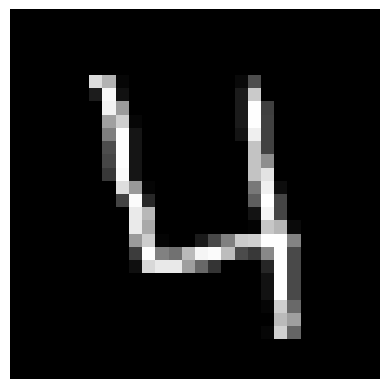

In [4]:
# visualizing one of the digits
some_digit = digits.loc[3,'pixel0':]
some_digit = np.array(some_digit)
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap='gray')
plt.axis("off")
plt.show()

In [5]:
# splitting the data into labels and features
y, X = digits['label'], digits.drop('label', axis=1)

In [6]:
# splitting data into train and test.
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=44)
for train_index, test_index in split.split(X, y):
    strat_X_train_set = X.loc[train_index]
    strat_y_train_set = y.loc[train_index]
    strat_X_test_set = X.loc[test_index]
    strat_y_test_set = y.loc[test_index]

In [18]:
# training using OVO and OVR
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier

svm_clf = SVC()
svm_clf.fit(strat_X_train_set, strat_y_train_set)

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(strat_X_train_set, strat_y_train_set)

ovo_clf = OneVsOneClassifier(SVC())
ovo_clf.fit(strat_X_train_set, strat_y_train_set)


OneVsOneClassifier(estimator=SVC())

In [58]:
test_digit = pd.DataFrame(strat_X_train_set.loc[4192]).T
display(svm_clf.decision_function(test_digit))
display(ovr_clf.decision_function(test_digit))
display(ovo_clf.decision_function(test_digit))
print(f"{' '*10}---------------------------------------------------")
test_digit = pd.DataFrame(strat_X_train_set.loc[34782]).T
display(svm_clf.decision_function(test_digit))
display(ovr_clf.decision_function(test_digit))
display(ovo_clf.decision_function(test_digit))

array([[-0.29583771,  2.71982777,  3.85437174,  9.31605706,  1.69673563,
         8.29070764,  0.69568168,  6.25756914,  6.24971127,  6.25020457]])

array([[-2.460827  , -2.14681489, -2.17194045,  1.60536736, -3.63222195,
        -1.80555793, -3.02133959, -1.38558683, -2.02130896, -1.91422299]])

array([[-0.2975485 ,  2.72089547,  3.8546722 ,  9.31616472,  1.69761603,
         8.29099027,  0.69579092,  6.25436301,  6.25076579,  6.24796487]])

          ---------------------------------------------------


array([[ 3.88905064,  0.70600413,  5.25241379,  2.73315701,  6.07944361,
         8.238555  ,  9.31670751, -0.3061509 ,  7.25806799,  1.72061782]])

array([[-2.27195454, -2.15838629, -2.31642703, -2.0778348 , -1.52091915,
        -2.29233737,  2.48119662, -3.14096255, -2.00192495, -2.3872041 ]])

array([[ 3.8758998 ,  0.70729622,  6.25182973,  2.73159996,  6.05769152,
         8.23275466,  9.31675277, -0.30573343,  6.25837875,  1.72081342]])